### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [26]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment/Dataset/Train")
data_dir_test = pathlib.Path("CNN_assignment/Dataset/Test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [16]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
                data_dir_train,
                validation_split=0.2,
                subset="training",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
                data_dir_train,
                validation_split=0.2,
                subset="validation",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

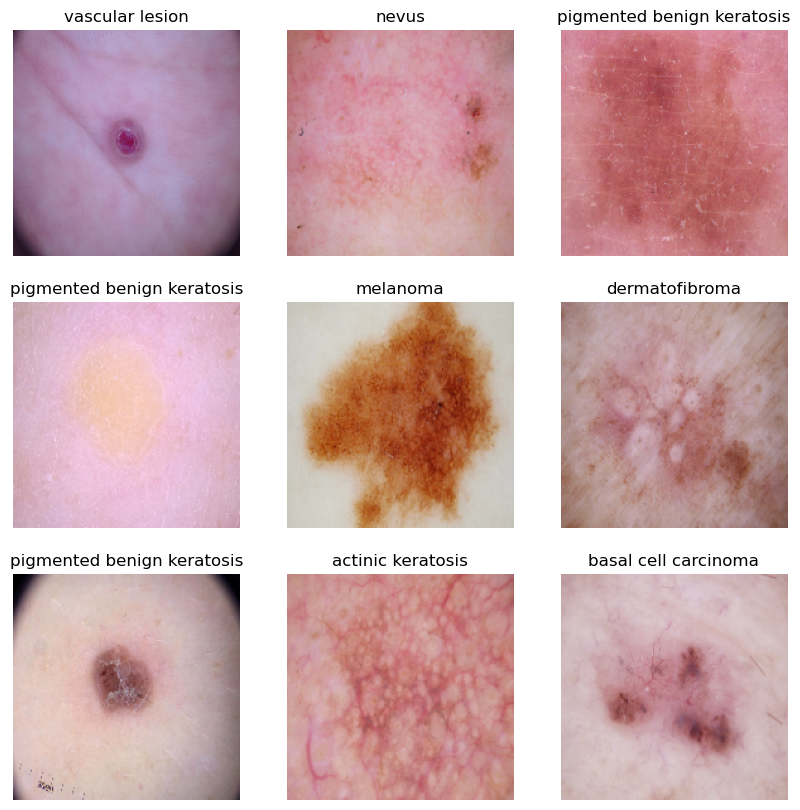

In [19]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
### Your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [22]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 371ms/step - loss: 1.9873 - accuracy: 0.2567 - val_loss: 1.8549 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 21s 372ms/step - loss: 1.7094 - accuracy: 0.3828 - val_loss: 1.6268 - val_accuracy: 0.4362
Epoch 3/20
56/56 [==============================] - 22s 385ms/step - loss: 1.5462 - accuracy: 0.4738 - val_loss: 1.4918 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 21s 370ms/step - loss: 1.4103 - accuracy: 0.5017 - val_loss: 1.4105 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 22s 388ms/step - loss: 1.3369 - accuracy: 0.5268 - val_loss: 1.3856 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 22s 387ms/step - loss: 1.2088 - accuracy: 0.5742 - val_loss: 1.3876 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 21s 383ms/step - loss: 1.1418 - accuracy: 0.5982 - val_loss: 1.4379 - val_accuracy: 0.5213

### Visualizing training results

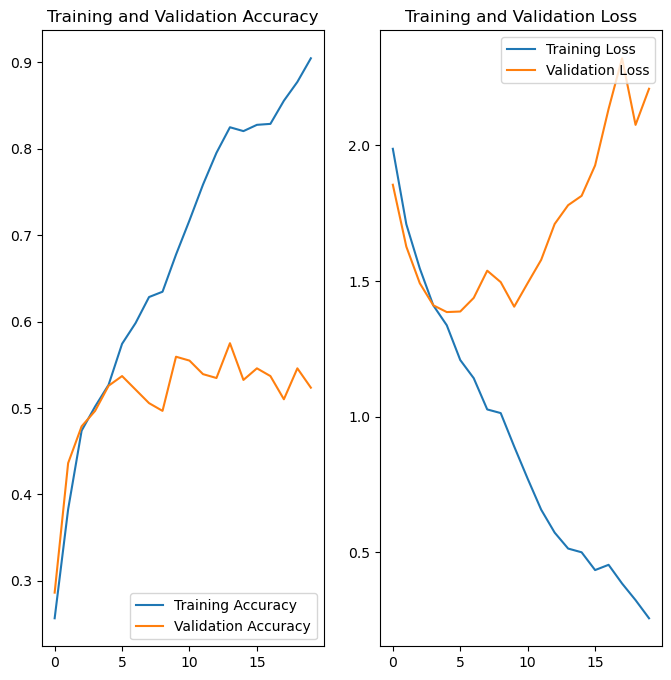

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 50% accuracy on the validation set.

### Write your findings here
### Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

### Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [26]:
#Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 


#Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

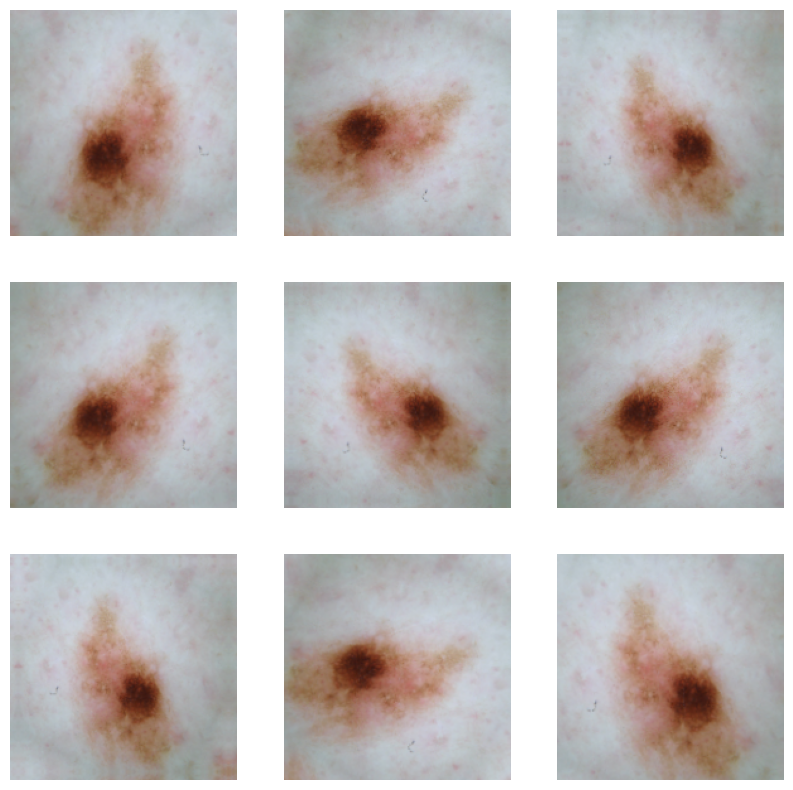

In [27]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
## Todo: add data augmentation to your model before training in the next step
## Create the model, compile and train the model
## Create model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#Compile and Train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#Summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 405ms/step - loss: 2.0196 - accuracy: 0.2427 - val_loss: 1.8910 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 24s 430ms/step - loss: 1.7965 - accuracy: 0.3482 - val_loss: 1.6272 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 24s 423ms/step - loss: 1.5822 - accuracy: 0.4280 - val_loss: 1.5713 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 24s 429ms/step - loss: 1.4817 - accuracy: 0.4766 - val_loss: 1.4222 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 24s 431ms/step - loss: 1.3903 - accuracy: 0.5234 - val_loss: 1.3316 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 24s 426ms/step - loss: 1.3106 - accuracy: 0.5396 - val_loss: 1.3561 - val_accuracy: 0.5660
Epoch 7/20
56/56 [==============================] - 24s 428ms/step - loss: 1.2708 - accuracy: 0.5469 - val_loss: 1.4126 - val_accuracy: 0.5235

Still we can see overfitting as val accuracy is 56% only

### Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [32]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

### Training the model

In [33]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 433ms/step - loss: 2.1074 - accuracy: 0.2227 - val_loss: 1.9320 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 23s 412ms/step - loss: 1.8005 - accuracy: 0.3493 - val_loss: 1.6267 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 24s 426ms/step - loss: 1.5672 - accuracy: 0.4414 - val_loss: 1.8033 - val_accuracy: 0.3848
Epoch 4/20
56/56 [==============================] - 27s 488ms/step - loss: 1.4786 - accuracy: 0.4872 - val_loss: 1.4414 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 25s 442ms/step - loss: 1.4389 - accuracy: 0.4950 - val_loss: 1.6452 - val_accuracy: 0.4407
Epoch 6/20
56/56 [==============================] - 25s 446ms/step - loss: 1.3553 - accuracy: 0.5240 - val_loss: 1.4629 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 26s 459ms/step - loss: 1.4414 - accuracy: 0.4833 - val_loss: 1.3791 - val_accuracy: 0.5436

### Visualizing the results

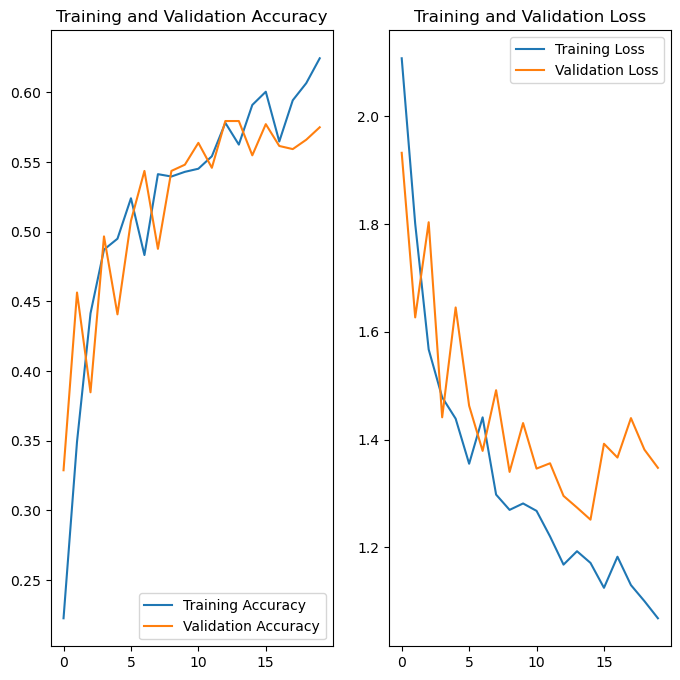

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Now model performed well compared to previous models however training accurancy is dropped , so there is chance of underfit due to data imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
## Your code goes here.
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df.sort_values(by=['No. of Image'])

,Class,No. of Image
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
melanoma and pigmented benign dominate the dataset


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
pip show numpy

Name: numpy
Version: 1.24.3
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: C:\Users\yubh1121\AppData\Local\anaconda3\Lib\site-packages
Requires: 
Required-by: astropy, Augmentor, bokeh, Bottleneck, contourpy, daal4py, datasets, datashader, datashape, gensim, h5py, holoviews, hvplot, imagecodecs, imageio, imbalanced-learn, matplotlib, mkl-fft, mkl-random, ml-dtypes, numba, numexpr, opt-einsum, pandas, patsy, pyarrow, pyerfa, PyWavelets, scikit-image, scikit-learn, scipy, seaborn, statsmodels, tables, tensorboard, tensorflow-intel, tifffile, transformers, xarray
Note: you may need to restart the kernel to use updated packages.


In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:



import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("CNN_assignment/Dataset/Train/"+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AD224A750>: 100%|█| 500/500 [00:03<00:00, 138.94 Samples


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21AD22AB250>: 100%|█| 500/500 [00:03<00:


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AD065A090>: 100%|█| 500/500 [00:03<00:00, 125.19 Samples


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x21AD219AD90>: 100%|█| 500/500 [00:17<00:00, 27.88 Sample


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x21AD06729D0>: 100%|█| 500/500 [00:16<00:00, 30.37 Samples/


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21A80ACEE90>: 100%|█| 500/500 [00:04<00:


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x21AD02B1110>: 100%|█| 500/500 [00:10<00


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AD22A1650>: 100%|█| 500/500 [00:04<00:00, 113.96 Samples


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Dataset/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21AD223DC10>: 100%|█| 500/500 [00:03<00:00, 132.75 Samples


In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,CNN_assignment\Dataset\Train\actinic keratosis...,actinic keratosis
1,CNN_assignment\Dataset\Train\actinic keratosis...,actinic keratosis
2,CNN_assignment\Dataset\Train\actinic keratosis...,actinic keratosis
3,CNN_assignment\Dataset\Train\actinic keratosis...,actinic keratosis
4,CNN_assignment\Dataset\Train\actinic keratosis...,actinic keratosis
...,...,...
2234,CNN_assignment\Dataset\Train\vascular lesion\I...,vascular lesion
2235,CNN_assignment\Dataset\Train\vascular lesion\I...,vascular lesion
2236,CNN_assignment\Dataset\Train\vascular lesion\I...,vascular lesion
2237,CNN_assignment\Dataset\Train\vascular lesion\I...,vascular lesion


<BarContainer object of 9 artists>

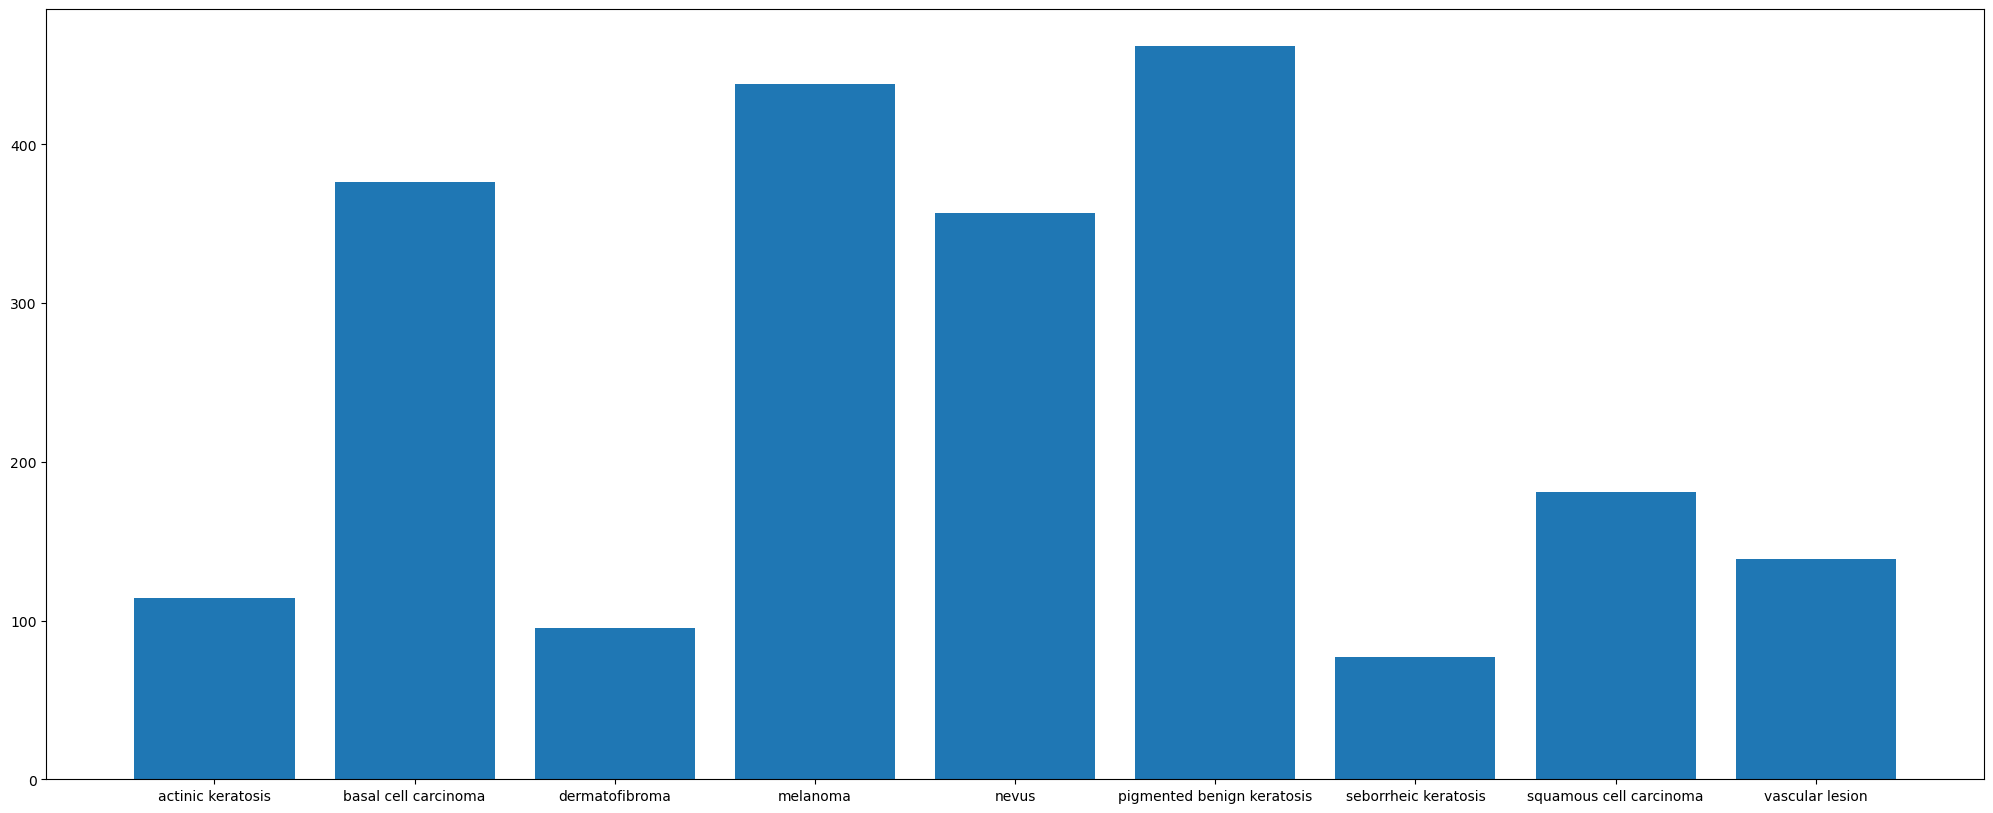

In [47]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [49]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:10]

['CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0eec1069-343c-4391-8c47-f59f3386d8a4.jpg',
 'CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_41ff3976-917f-4c14-b165-b7d18fb2f98a.jpg',
 'CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b5456efa-f183-4cfe-a593-3ef64790ef3b.jpg',
 'CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d5c6b518-574a-43be-83df-7e3c3590ca7f.jpg',
 'CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_e42cfd5f-fd0f-4b1c-af33-b1d84f69c7e1.jpg',
 'CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_124852eb-9585-42f1-9366-8d21a1aff257.jpg',
 'CNN_assignment\\Dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_20106a7

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [68]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [63]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])


new_df = pd.concat([original_df,df2])


In [64]:
df2.shape

(4500, 2)

In [65]:
original_df.shape

(2239, 2)

In [66]:
new_df.shape

(6739, 2)

In [67]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [69]:
batch_size = 32
img_height = 180
img_width = 180

In [70]:
import pathlib
data_dir_train=pathlib.Path("CNN_assignment/Dataset/Train/")
data_dir_train

image_count_train1 = len(list(glob.glob("CNN_assignment/Dataset/Train/**/*.jpg", recursive=True)))
print(image_count_train1)

6739


#### **Todo:** Create a training dataset

In [71]:
data_dir_train=pathlib.Path("CNN_assignment/Dataset/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [73]:
## your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [74]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [75]:
#epochs = 30
## Your code goes here, use 50 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 70s 408ms/step - loss: 1.8759 - accuracy: 0.2897 - val_loss: 1.4992 - val_accuracy: 0.4150
Epoch 2/30
169/169 [==============================] - 76s 448ms/step - loss: 1.4347 - accuracy: 0.4440 - val_loss: 1.3371 - val_accuracy: 0.5048
Epoch 3/30
169/169 [==============================] - 76s 449ms/step - loss: 1.2400 - accuracy: 0.5336 - val_loss: 1.1822 - val_accuracy: 0.5679
Epoch 4/30
169/169 [==============================] - 81s 475ms/step - loss: 1.0571 - accuracy: 0.6129 - val_loss: 1.0867 - val_accuracy: 0.6036
Epoch 5/30
169/169 [==============================] - 79s 463ms/step - loss: 0.9017 - accuracy: 0.6719 - val_loss: 0.9469 - val_accuracy: 0.6481
Epoch 6/30
169/169 [==============================] - 80s 470ms/step - loss: 0.7288 - accuracy: 0.7368 - val_loss: 0.9345 - val_accuracy: 0.6800
Epoch 7/30
169/169 [==============================] - 81s 475ms/step - loss: 0.5989 - accuracy: 0.7912 - val_loss: 0.7753 - val_ac

#### **Todo:**  Visualize the model results

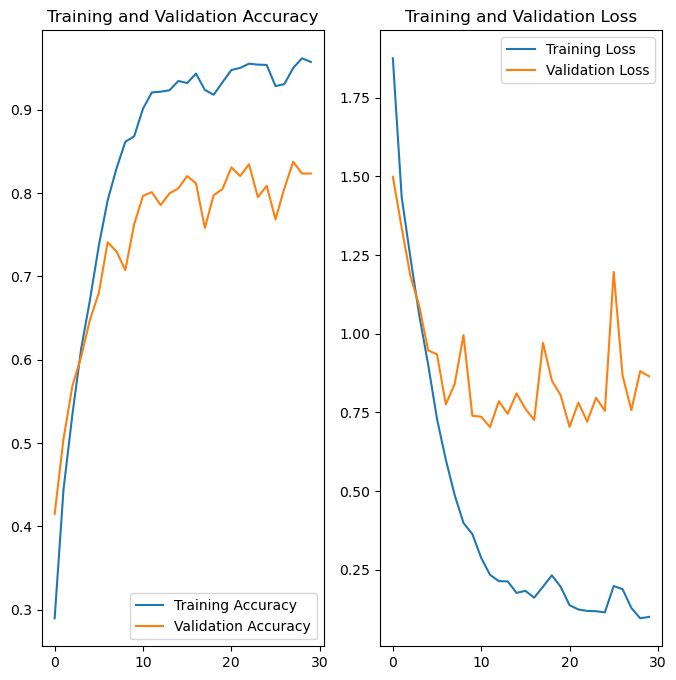

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. Class rebalance helped to improve the performance of model.
2. The difference between training and validation dataset is about 14-15%, which shows that still there is overfitting.
3. Problem of overfitting can be solved by adding more layers, droupout layers.
4. The model can be further imporoved by tuning parameter,hyperparameters.

Lets add Dropout layer after each convol layer

In [77]:
num_classes = len(class_names)

model = Sequential([
    
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    layers.Dropout(0.3),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    layers.Dropout(0.3),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [78]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [79]:
#epochs = 30
## Your code goes here, use 50 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 83s 482ms/step - loss: 2.1939 - accuracy: 0.1821 - val_loss: 1.9289 - val_accuracy: 0.2621
Epoch 2/30
169/169 [==============================] - 85s 499ms/step - loss: 1.7470 - accuracy: 0.3310 - val_loss: 1.7435 - val_accuracy: 0.3860
Epoch 3/30
169/169 [==============================] - 100s 591ms/step - loss: 1.5317 - accuracy: 0.4154 - val_loss: 1.5138 - val_accuracy: 0.4432
Epoch 4/30
169/169 [==============================] - 108s 634ms/step - loss: 1.3884 - accuracy: 0.4759 - val_loss: 1.4150 - val_accuracy: 0.4684
Epoch 5/30
169/169 [==============================] - 89s 524ms/step - loss: 1.2842 - accuracy: 0.5139 - val_loss: 1.3819 - val_accuracy: 0.5071
Epoch 6/30
169/169 [==============================] - 94s 555ms/step - loss: 1.2021 - accuracy: 0.5499 - val_loss: 1.2807 - val_accuracy: 0.5189
Epoch 7/30
169/169 [==============================] - 88s 516ms/step - loss: 1.0944 - accuracy: 0.5862 - val_loss: 1.1285 - val_

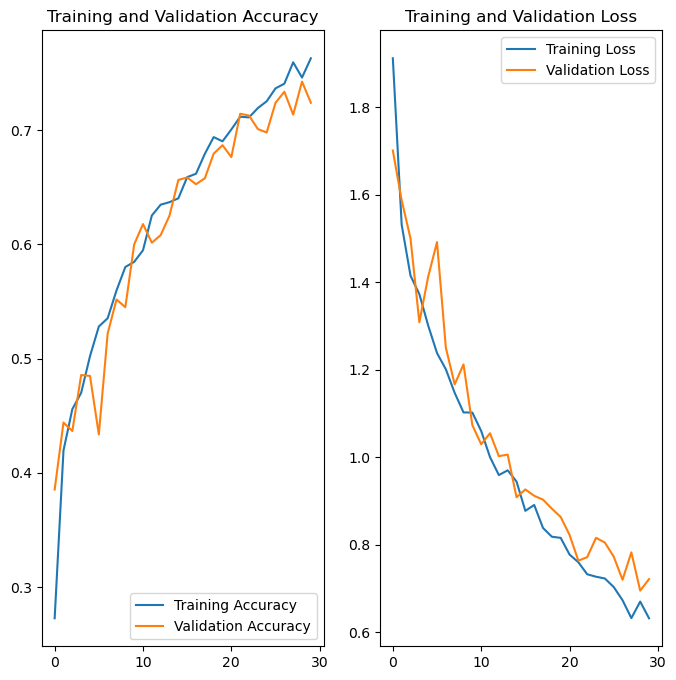

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()